Step 1 - Setting Up the Research Environment 

In [1]:
# For data handling and numerical operations
import pandas as pd
import numpy as np
import os
import glob

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# For saving final model
import joblib

# To keep output clean
import warnings
warnings.filterwarnings('ignore')

Step 2 - Data Preparation & Sampling

In [ ]:
print("Data Preparation Pipeline")

# Configuration for data pipeline
data_path = 'IDS2018_Data/'
sampled_csv_path = 'IDS2018_Sampled_AllLabels.csv'   # Creating a sampled file with original labels.
chunk_size = 100000
sample_fraction = 0.1

#starting with Memory-Safe Cleaning
print("\nStage 2.1: Cleaning raw CSV files while keeping original labels for Multi-class classification...")

temp_cleaned_path = 'IDS2018_Cleaned.csv'  #temporary file to store the cleaned full dataset

try:
    csv_files = glob.glob(os.path.join(data_path, "*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found at '{data_path}'.")

    is_first_chunk = True
    for filename in csv_files:
        with pd.read_csv(filename, chunksize=chunk_size, low_memory=False, on_bad_lines='skip') as reader:
            for chunk in reader:
                # cleaning without simplifying the 'label' column
                chunk.columns = chunk.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
                numeric_columns = chunk.select_dtypes(include=np.number).columns
                chunk[numeric_columns] = chunk[numeric_columns].replace([np.inf, -np.inf], np.nan)
                chunk.dropna(inplace=True)
             
                if is_first_chunk:
                    chunk.to_csv(temp_cleaned_path, index=False, mode='w')
                    is_first_chunk = False
                else:
                    chunk.to_csv(temp_cleaned_path, index=False, mode='a', header=False)
    print("Full dataset has been cleaned successfully.")

except Exception as e:
    print(f"An error occurred during the cleaning process: {e}")


#Stratifing cleaned dataset
print("\nStage 2.2: Creating a stratified sample")
try:
    is_first_sample_chunk = True
    with pd.read_csv(temp_cleaned_path, chunksize=chunk_size) as reader:
        for chunk in reader:
            # Stratifying  with original 'label' column to ensure all attack types are represented.
            sampled_chunk = chunk.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=42))
            if is_first_sample_chunk:
                sampled_chunk.to_csv(sampled_csv_path, index=False, mode='w')
                is_first_sample_chunk = False
            else:
                sampled_chunk.to_csv(sampled_csv_path, index=False, mode='a', header=False)
    print(f"Final sampled dataset saved to - '{sampled_csv_path}'.")
   
    os.remove(temp_cleaned_path)    # removed temporary file

except Exception as e:
    print(f"An error occurred during the sampling process: {e}")


# Stage 2.3: Loading and Inspecting the Final Dataset
print("\nStage 2.3: Loading the final dataset...")
try:
    ids_data = pd.read_csv(sampled_csv_path)
    print("Final Dataset loaded successfully.")
    print(f"\nFinal dataset now has {len(ids_data)} rows.")
    print("\nDistribution of Attacks (top 10):")
    print(ids_data['label'].value_counts().head(10))
except Exception as e:
    print(f"An error occurred while loading the final data: {e}")

Data Preparation Pipeline

Stage 2.1: Cleaning raw CSV files while keeping original labels for Multi-class classification...
Full dataset has been cleaned successfully.

Stage 2.2: Creating a stratified sample
Final sampled dataset saved to - 'IDS2018_Sampled_AllLabels.csv'.

Stage 2.3: Loading the final dataset...
Final Dataset loaded successfully.

Final dataset now has 962515 rows.

Distribution of Attacks (top 10):
An error occurred while loading the final data: 'Attack Type'


Step 3 - Exploratory Data Analysis (EDA)


Starting Exploratory Data Analysis
Successfully loaded the final dataset for analysis.

Analyzing the overall distribution of traffic


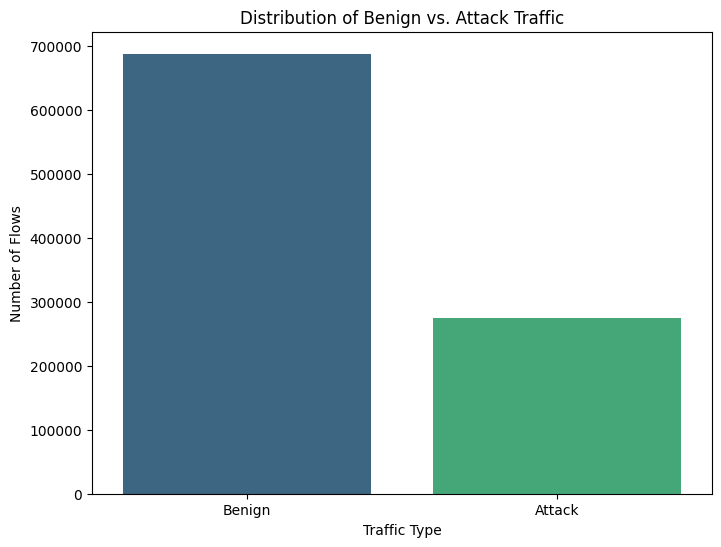

Insight: The data is imbalanced, so not surprisingly the use of 'stratify' on our data split is a vital step.

Investigating network protocol usage...


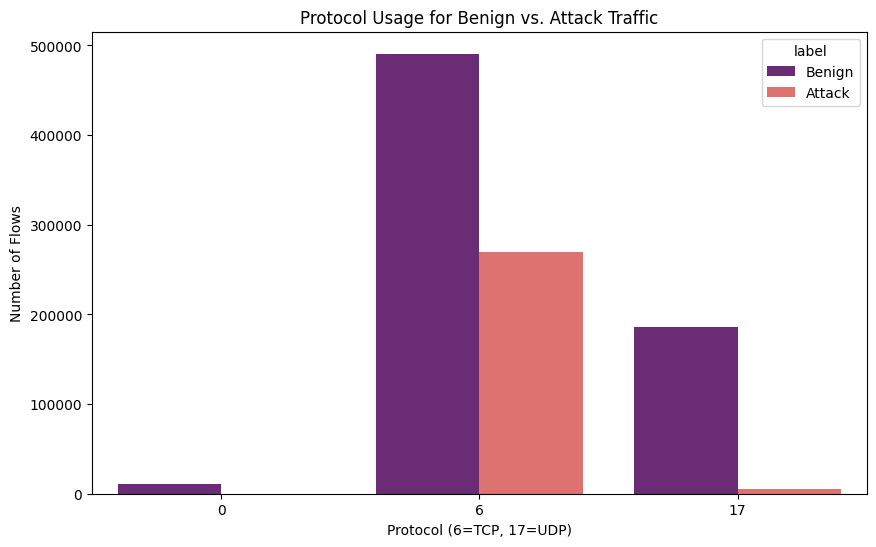

Insight: There is a clear pattern here. They both use TCP, but almost all UDP traffic in this dataset is malicious. This will be a very strong feature for our model.

Investigating the most common destination ports


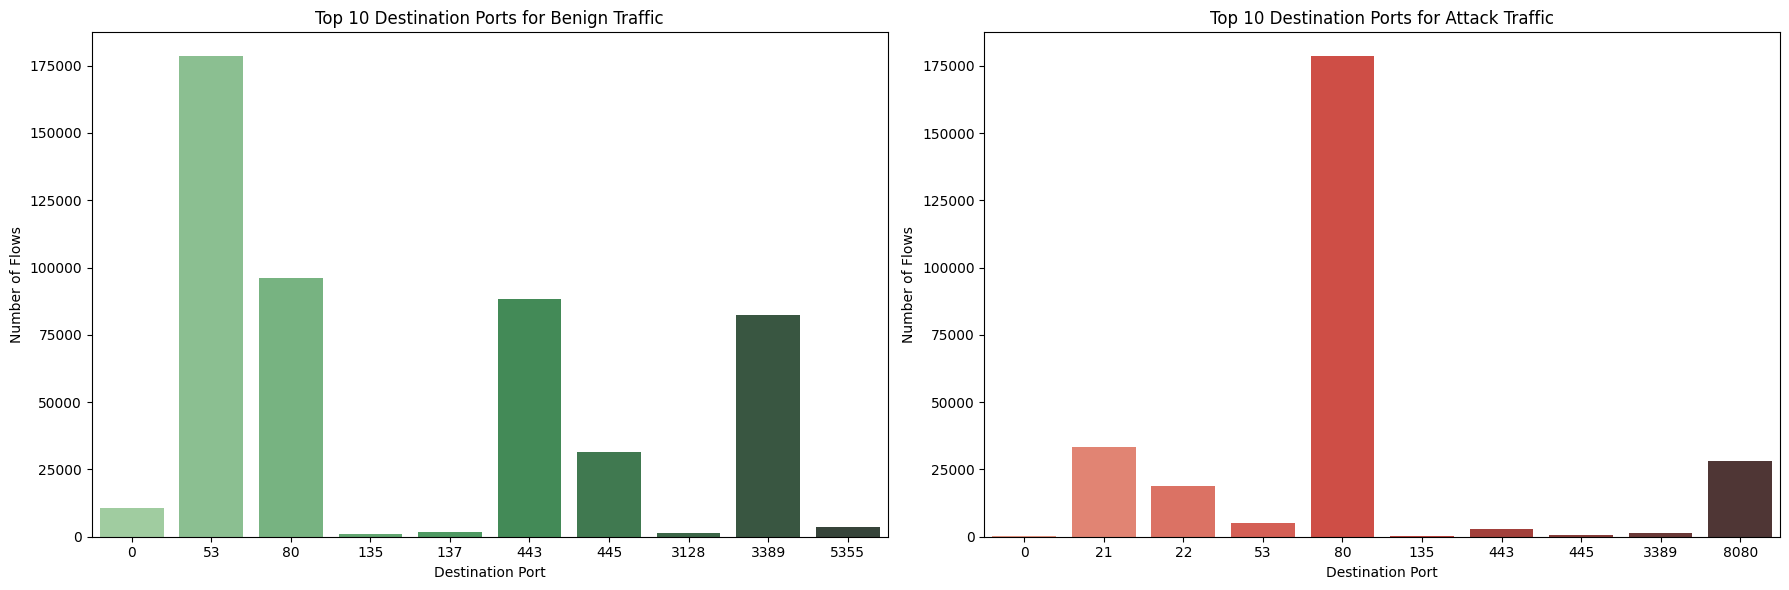

Insight: Attackers' goals can be revealed by analysis. High rates of attacks targeting port 80 (HTTP) or port 443 (HTTPS) would reflect a web application attack direction.

Analyzing feature correlation to identify redundancy


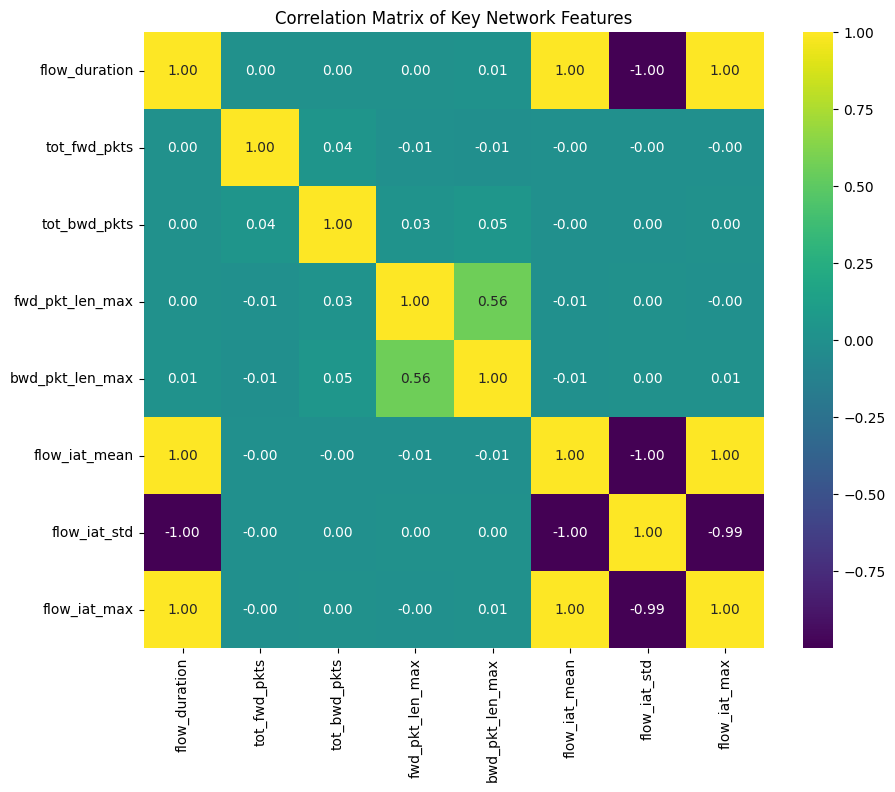

Insight: The heatmap reveals very high correlations (values > 0.9) among some features. It suggests they contain redundant information and we can consider it while choosing features.


In [3]:
print("\nStarting Exploratory Data Analysis")

try:
    # loading final dataset from previous step
    sampled_csv_path = 'IDS2018_Sampled_AllLabels.csv'
    network_traffic_df = pd.read_csv(sampled_csv_path)
    print("Successfully loaded the final dataset for analysis.")

    # Creating temporary binary label for visualization
    EDA_labels = network_traffic_df['label'].apply(lambda x: 'Benign' if 'benign' in str(x).lower() else 'Attack')

    # Analysis 1: How is our dataset composed?
    print("\nAnalyzing the overall distribution of traffic")    #high-level view of data's composition
    plt.figure(figsize=(8, 6))
    sns.countplot(x=EDA_labels, palette="viridis")
    plt.title('Distribution of Benign vs. Attack Traffic')
    plt.xlabel('Traffic Type')
    plt.ylabel('Number of Flows')
    plt.show()
    print("Insight: The data is imbalanced, so not surprisingly the use of 'stratify' on our data split is a vital step.")

    #Analysis 2: What network protocols do attackers prefer?
    print("\nInvestigating network protocol usage...")   # investigating between attackers and normal users behaviour at the protocol level
    plt.figure(figsize=(10, 6))
    sns.countplot(x='protocol', hue=EDA_labels, data=network_traffic_df, palette="magma")
    plt.title('Protocol Usage for Benign vs. Attack Traffic')
    plt.xlabel('Protocol (6=TCP, 17=UDP)')
    plt.ylabel('Number of Flows')
    plt.show()
    print("Insight: There is a clear pattern here. They both use TCP, but almost all UDP traffic in this dataset is malicious. This will be a very strong feature for our model.")

    #Analysis 3: What network services are being targeted?
    print("\nInvestigating the most common destination ports")  #investigating which services are being targeted.
    top_ports_benign = network_traffic_df[EDA_labels == 'Benign']['dst_port'].value_counts().head(10)
    top_ports_attack = network_traffic_df[EDA_labels == 'Attack']['dst_port'].value_counts().head(10)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x=top_ports_benign.index, y=top_ports_benign.values, palette="Greens_d")
    plt.title('Top 10 Destination Ports for Benign Traffic')
    plt.xlabel('Destination Port')
    plt.ylabel('Number of Flows')

    plt.subplot(1, 2, 2)
    sns.barplot(x=top_ports_attack.index, y=top_ports_attack.values, palette="Reds_d")
    plt.title('Top 10 Destination Ports for Attack Traffic')
    plt.xlabel('Destination Port')
    plt.ylabel('Number of Flows')
    plt.tight_layout()
    plt.show()
    print("Insight: Attackers' goals can be revealed by analysis. High rates of attacks targeting port 80 (HTTP) or port 443 (HTTPS) would reflect a web application attack direction.")

    #Analysis 4: Do any features provide redundant information?
    print("\nAnalyzing feature correlation to identify redundancy")
    correlation_features = [
        'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts', 'fwd_pkt_len_max',
        'bwd_pkt_len_max', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max'
    ]
    correlation_matrix = network_traffic_df[correlation_features].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlation Matrix of Key Network Features')
    plt.show()
    print("Insight: The heatmap reveals very high correlations (values > 0.9) among some features. It suggests they contain redundant information and we can consider it while choosing features.")

except FileNotFoundError:
    print(f"\nFATAL ERROR: The data file '{sampled_csv_path}' was not found.")
    print("Please verify if you have successfully run the Data Preparation step.")
except Exception as e:
    print(f"An unexpected error occurred during the EDA process: {e}")

Step 4 - Training and evaluation 


Result for 70/30 Data Split
Data prepared for 70/30 split.
Training set has 673760 samples.
Testing set has 288755 samples.
Number of features being used: 78
------------------------------

Training Random Forest...

Training XGBoost...

Training Logistic Regression...

Result for 80/20 Data Split
Data prepared for 80/20 split.
Training set has 770012 samples.
Testing set has 192503 samples.
Number of features being used: 78
------------------------------

Training Random Forest...

Training XGBoost...

Training Logistic Regression...

Result for 90/10 Data Split
Data prepared for 90/10 split.
Training set has 866263 samples.
Testing set has 96252 samples.
Number of features being used: 78
------------------------------

Training Random Forest...

Training XGBoost...

Training Logistic Regression...

Final Consolidated Results Across All Experiments
                    Accuracy                 F1-Score                
Split                  70/30   80/20   90/10    70/30   80/20   90/

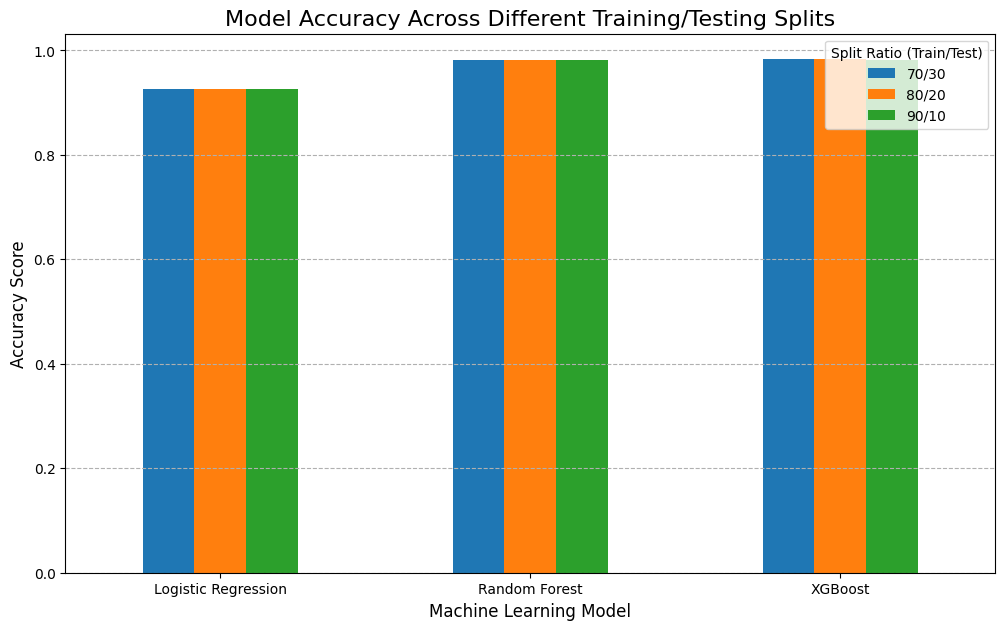

In [4]:
# A list to store all final results for comparison.
spliting_results = []

# The split ratios we want to test.
split_ratios = [0.3, 0.2, 0.1] # Corresponds to 70/30, 80/20, 90/10

for split in split_ratios:
    training_ratio = int((1 - split) * 100)
    testing_ratio = int(split * 100)
    print("\n" + "="*50)
    print(f"Result for {training_ratio}/{testing_ratio} Data Split")
    print("="*50)

    try:
        # Stage 4.1: Data Preparation for the split
        features_to_drop = ['label', 'timestamp']
        X = ids_data.drop(columns=features_to_drop, errors='ignore').select_dtypes(include=np.number)

        binary_labels = ids_data['label'].apply(lambda x: 'Benign' if 'benign' in str(x).lower() else 'Attack') # creating binary classification
        y = binary_labels.map({'Benign': 0, 'Attack': 1})

        # Data Splitting
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=split, random_state=42, stratify=y
        )
         

        # Feature Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
        X_test = pd.DataFrame(X_test_scaled, columns=X.columns)
        print(f"Data prepared for {training_ratio}/{testing_ratio} split.")
        print(f"Training set has {X_train.shape[0]} samples.")
        print(f"Testing set has {X_test.shape[0]} samples.")
        print(f"Number of features being used: {X_train.shape[1]}")
        print("-" * 30)

        #Stage 4.2: Train and Evaluate Models for the split 

        # 1. Random Forest (Primary Model)
        print("\nTraining Random Forest...")
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1)
        rf_model.fit(X_train, y_train)
        rf_predictions = rf_model.predict(X_test)
        rf_report = classification_report(y_test, rf_predictions, output_dict=True)
        spliting_results.append({
            'Split': f'{training_ratio}/{testing_ratio}', 'Model': 'Random Forest',
            'Accuracy': rf_report['accuracy'], 'F1-Score': rf_report['weighted avg']['f1-score']
        })

        # 2. XGBoost (Benchmark Model)
        print("\nTraining XGBoost...")
        xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_predictions = xgb_model.predict(X_test)
        xgb_report = classification_report(y_test, xgb_predictions, output_dict=True)
        spliting_results.append({
            'Split': f'{training_ratio}/{testing_ratio}', 'Model': 'XGBoost',
            'Accuracy': xgb_report['accuracy'], 'F1-Score': xgb_report['weighted avg']['f1-score']
        })

        # 3. Logistic Regression (Baseline Model)
        print("\nTraining Logistic Regression...")
        lr_model = LogisticRegression(max_iter=1000, random_state=42)
        lr_model.fit(X_train, y_train)
        lr_predictions = lr_model.predict(X_test)
        lr_report = classification_report(y_test, lr_predictions, output_dict=True)
        spliting_results.append({
            'Split': f'{training_ratio}/{testing_ratio}', 'Model': 'Logistic Regression',
            'Accuracy': lr_report['accuracy'], 'F1-Score': lr_report['weighted avg']['f1-score']
        })
        
    except Exception as e:
        print(f"An error occurred during the {training_ratio}/{testing_ratio} experiment: {e}")

pd.set_option('display.max_columns', None)
#Final Results Consolidation
print("\n" + "="*50)
print("Final Consolidated Results Across All Experiments")
print("="*50)

results_df = pd.DataFrame(spliting_results)
final_comparison_table = results_df.pivot(index='Model', columns='Split', values=['Accuracy', 'F1-Score'])
# Reorder for a logical presentation
final_comparison_table = final_comparison_table.reindex(columns=['70/30', '80/20', '90/10'], level='Split')

print(final_comparison_table.round(4))

# Visualize the main results for the report
final_comparison_table['Accuracy'].plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Model Accuracy Across Different Training/Testing Splits', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Machine Learning Model', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.legend(title='Split Ratio (Train/Test)')
plt.show()

Step 5 - Rigorous Model Training with GridSearchCV (80/20 Split)

In [5]:
print(" Starting Rigorous Training for the Primary Model with 80/20 Split")

try:
    # Data Preparation for the 80/20 Split
    binary_labels = network_traffic_df['label'].apply(lambda x: 'Benign' if 'benign' in str(x).lower() else 'Attack')
    y = binary_labels.map({'Benign': 0, 'Attack': 1})

    # Define features and drop non-numeric columns
    features_to_drop = ['label', 'timestamp']
    X = network_traffic_df.drop(columns=features_to_drop, errors='ignore').select_dtypes(include=np.number)

    # Split the data 80/20, ensuring class balance is maintained.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X.columns)
    print("Data successfully prepared for the 80/20 split.")

    #Rigorous Hyperparameter Tuning with GridSearchCV
    print("\nSearching for the best model configuration")
    parameter_grid = {
        'n_estimators': [100, 200], 'max_depth': [20, 40],
        'min_samples_leaf': [1, 5], 'max_features': ['sqrt']
    }
    grid_search_tuner = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid=parameter_grid, cv=3, scoring='accuracy', verbose=1
    )
    grid_search_tuner.fit(X_train, y_train)
    best_rf_model = grid_search_tuner.best_estimator_
    print(f"\nBest Hyperparameters Found: {grid_search_tuner.best_params_}")

    #Overfitting Analysis
    print("\nOverfitting Analysis")
    training_accuracy = best_rf_model.score(X_train, y_train)
    testing_accuracy = best_rf_model.score(X_test, y_test)
    accuracy_difference = training_accuracy - testing_accuracy
    print(f"Model Accuracy on Training Data: {training_accuracy:.4f}")
    print(f"Model Accuracy on Testing Data: {testing_accuracy:.4f}")
    if (accuracy_difference < 0.05):
        print("Result: Excellent generalization. The model's accuracy is genuine.")
    else:
        print("Result: High difference suggests potential overfitting.")

    #Final Evaluation Report
    print("\nFinal Performance Report for the Binary Model")
    binary_predictions = best_rf_model.predict(X_test)
    print(classification_report(y_test, binary_predictions, target_names=['Benign', 'Attack']))

    # Saving Files for the Binary Prototype
    print("\nSaving files for the BINARY prototype")
    joblib.dump(best_rf_model, 'binary_model.joblib')
    joblib.dump(scaler, 'binary_scaler.joblib')
    joblib.dump(X_train.columns.tolist(), 'binary_feature_columns.joblib')
    print("Binary model and supporting files saved successfully.")

except Exception as e:
    print(f"An error occurred during the binary model training process: {e}")

 Starting Rigorous Training for the Primary Model with 80/20 Split
Data successfully prepared for the 80/20 split.

Searching for the best model configuration
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best Hyperparameters Found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}

Overfitting Analysis
Model Accuracy on Training Data: 0.9850
Model Accuracy on Testing Data: 0.9827
Result: Excellent generalization. The model's accuracy is genuine.

Final Performance Report for the Binary Model
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99    137538
      Attack       1.00      0.94      0.97     54965

    accuracy                           0.98    192503
   macro avg       0.99      0.97      0.98    192503
weighted avg       0.98      0.98      0.98    192503


Saving files for the BINARY prototype
Binary model and supporting files saved successfully.


Step 6 -  Interpreting the Model


Interpreting the Model's Logic with Feature Importance

Analyzing which features were most important for the model's decisions
Top 20 most influential features:
              feature  importance
0            dst_port    0.114832
66  init_fwd_win_byts    0.066289
5     totlen_fwd_pkts    0.049607
16        flow_pkts/s    0.045089
69   fwd_seg_size_min    0.044240
37         fwd_pkts/s    0.041069
54   fwd_seg_size_avg    0.040197
9    fwd_pkt_len_mean    0.039505
35     fwd_header_len    0.036985
63   subflow_fwd_byts    0.036857
67  init_bwd_win_byts    0.036417
7     fwd_pkt_len_max    0.035684
2       flow_duration    0.017670
21        fwd_iat_tot    0.017298
22       fwd_iat_mean    0.017275
15        flow_byts/s    0.016276
19       flow_iat_max    0.016216
43        pkt_len_var    0.016109
24        fwd_iat_max    0.015068
13   bwd_pkt_len_mean    0.014075


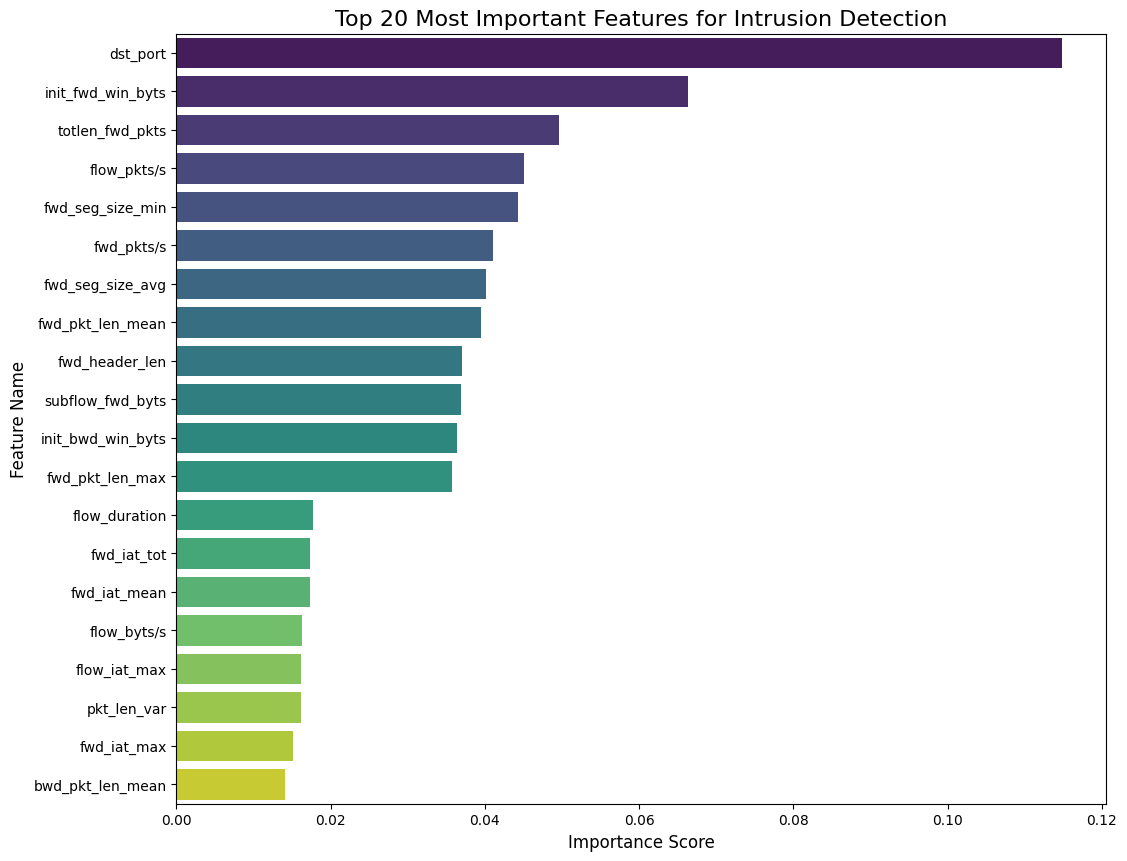

In [6]:
print("\nInterpreting the Model's Logic with Feature Importance")

try:
    #Analyzing Top 20 Most Influential Features
    print("\nAnalyzing which features were most important for the model's decisions")
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_rf_model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    print("Top 20 most influential features:")
    print(feature_importances.head(20))

    # --- Visualize the top 20 features ---
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.title('Top 20 Most Important Features for Intrusion Detection', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)
    plt.show()

except NameError:
    print("Error: 'best_rf_model' is not defined. Please ensure the rigorous training step has been run successfully.")
except Exception as e:
    print(f"An error occurred during feature importance analysis: {e}")

Step 7 - Multi-Class Model Training

In [7]:
print("\nStarting Multi-Class Classification")

try:
    # 1. Loading sampled data with detailed labels
    multi_class_df = pd.read_csv('IDS2018_Sampled_AllLabels.csv')
    multi_class_df.dropna(subset=['label'], inplace=True)
    
    # 2. Creating granular labels for multi-class classification
    def map_label_to_category(label):
        label = str(label).lower()
        if 'benign' in label: return 'Benign'
        if 'hulk' in label: return 'DoS-Hulk'
        if 'goldeneye' in label: return 'DoS-GoldenEye'
        if 'slowloris' in label: return 'DoS-Slowloris'
        if 'slowhttptest' in label: return 'DoS-SlowHTTPTest'
        if 'ssh-bruteforce' in label: return 'SSH-BruteForce'
        if 'ftp-bruteforce' in label: return 'FTP-BruteForce'
        if 'bot' in label: return 'Botnet'
        if 'web attack' in label or 'xss' in label or 'sql injection' in label: return 'Web Attack'
        if 'infilteration' in label: return 'Infiltration'
        return 'Generic Attack'

    network_traffic_df['attack_category'] = network_traffic_df['label'].apply(map_label_to_category)
    print("\nGranular multi-class label distribution:")
    print(network_traffic_df['attack_category'].value_counts())

    # Preparing data for the multi-class model
    features_to_drop = ['label', 'timestamp', 'attack_category']
    X_multi = network_traffic_df.drop(columns=features_to_drop, errors='ignore').select_dtypes(include=np.number)
    y_multi_text = network_traffic_df['attack_category']

    label_encoder = LabelEncoder()
    y_multi = label_encoder.fit_transform(y_multi_text)
    class_names = label_encoder.classes_
    
    X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi)
    scaler_mc = StandardScaler()
    X_train_mc_scaled = scaler_mc.fit_transform(X_train_mc)
    X_test_mc_scaled = scaler_mc.transform(X_test_mc)

    # Training the multi-class model
    print("\nTraining the Multi-Class Random Forest")
    best_multi_class_model = RandomForestClassifier(         # Using 'class_weight'for imbalanced multi-class data.
        n_estimators=150, max_depth=40, min_samples_leaf=5,
        random_state=42, n_jobs=-1, class_weight='balanced'
    )
    best_multi_class_model.fit(X_train_mc_scaled, y_train_mc)
    print("Multi-class model training completed.")

    #Evaluating and Saving the new model
    print("\nFinal Multi-Class Performance Report")
    multi_class_predictions = best_multi_class_model.predict(X_test_mc_scaled)
    print(classification_report(y_test_mc, multi_class_predictions, target_names=label_encoder.classes_))
    report_dict = classification_report(y_test_mc, multi_class_predictions, target_names=class_names, output_dict=True)     # report as dictionary
    
    # Converting the dictionary to a pandas DataFrame
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Display the formatted report, rounded to 2 decimal places
    print(report_df.round(2))

    print("\nSaving files for the multi-class prototype")
    joblib.dump(best_multi_class_model, 'multi_class_model.joblib')
    joblib.dump(scaler_mc, 'multi_class_scaler.joblib')
    joblib.dump(label_encoder, 'multi_class_encoder.joblib')
    joblib.dump(X_multi.columns.tolist(), 'multi_class_features.joblib')
    print("All necessary files for the multi-class prototype have been Saved.")

except Exception as e:
    print(f"An error occurred during the multi-class analysis: {e}")


Starting Multi-Class Classification

Granular multi-class label distribution:
attack_category
Benign              687690
Generic Attack      126453
DoS-Hulk             46192
Botnet               28620
FTP-BruteForce       19336
SSH-BruteForce       18759
Infiltration         16194
DoS-SlowHTTPTest     13989
DoS-GoldenEye         4151
DoS-Slowloris         1099
Web Attack              32
Name: count, dtype: int64

Training the Multi-Class Random Forest
Multi-class model training completed.

Final Multi-Class Performance Report
                  precision    recall  f1-score   support

          Benign       0.99      0.91      0.94    137538
          Botnet       1.00      1.00      1.00      5724
   DoS-GoldenEye       1.00      1.00      1.00       830
        DoS-Hulk       1.00      1.00      1.00      9238
DoS-SlowHTTPTest       0.52      0.99      0.68      2798
   DoS-Slowloris       1.00      1.00      1.00       220
  FTP-BruteForce       0.98      0.33      0.50      3867
 

Step 8 - Generating Test Samples for prototype

In [ ]:
print("\nFinding data samples for all attack types")

try:
    # useing mapping function to find samples
    def map_label_to_category(label):
        label = str(label).lower()
        if 'benign' in label: return 'Benign'
        if 'hulk' in label: return 'DoS-Hulk'
        if 'goldeneye' in label: return 'DoS-GoldenEye'
        if 'slowloris' in label: return 'DoS-Slowloris'
        if 'slowhttptest' in label: return 'DoS-SlowHTTPTest'
        if 'ssh-bruteforce' in label: return 'SSH-BruteForce'
        if 'ftp-bruteforce' in label: return 'FTP-BruteForce'
        if 'bot' in label: return 'Botnet'
        if 'web attack' in label or 'xss' in label or 'sql injection' in label: return 'Web Attack'
        if 'infilteration' in label: return 'Infiltration'
        return 'Generic Attack'

    network_traffic_df['attack_category_for_sampling'] = network_traffic_df['label'].apply(map_label_to_category)
    
    # ensuring correct column order
    features_to_drop_sampling = ['label', 'timestamp', 'attack_category_for_sampling']
    X_for_sampling = network_traffic_df.drop(columns=features_to_drop_sampling, errors='ignore').select_dtypes(include=np.number)
    
    #Unique attack categories list
    available_categories = network_traffic_df['attack_category_for_sampling'].unique().tolist()
    print(f"\nSearching for one sample from each of these categories: {available_categories}")

    # Looping through each category to get a sample data
    for category in available_categories:
        print("\n" + "="*50)
        print(f"Data Sample for: {category}")
        sample_df = network_traffic_df[network_traffic_df['attack_category_for_sampling'] == category].head(1)

        if not sample_df.empty:
            #ensuring correct column order by Isolating the numerical features
            attack_features_unscaled = sample_df[X_for_sampling.columns]
            test_string_to_copy = ','.join([str(val) for val in attack_features_unscaled.iloc[0].values])
            print(test_string_to_copy)
        else:
            print(f"Could not find a sample for '{category}'.")

except NameError:
    print("Error: The 'network_traffic_df' DataFrame was not found. Please run Part 2 again.")
except Exception as e:
    print(f"An error occurred: {e}")


Finding data samples for all attack types

Searching for one sample from each of these categories: ['Benign', 'Botnet', 'Generic Attack', 'Web Attack', 'DoS-GoldenEye', 'DoS-Hulk', 'DoS-SlowHTTPTest', 'DoS-Slowloris', 'FTP-BruteForce', 'Infiltration', 'SSH-BruteForce']

Data Sample for: Benign
(Copy the entire line below and paste it into the web app)
443.0,6.0,121840.0,7.0,8.0,346.0,3935.0,189.0,0.0,49.4285714285714,76.87187856612921,1460.0,0.0,491.875,647.827233913487,35136.0,123.0,8702.857142857141,10040.1603025599,32142.0,1.0,105022.0,17503.6666666667,13081.2057497261,32183.0,285.0,104753.0,14964.7142857143,18480.6389654532,49746.0,1.0,0.0,0.0,0.0,0.0,152.0,172.0,57.4523965856861,65.6598818122127,0.0,1460.0,267.5625,502.023368479994,252027.4625,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,285.4,49.4285714285714,491.875,0.0,0.0,0.0,0.0,0.0,0.0,7.0,346.0,8.0,3935.0,8192.0,946.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Data Sample for: Botnet
(Copy the entire line below and paste it into the